In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from fastai.vision.all import *
from fastcore.parallel import *
import timm

In [ ]:
#!pip install kaggle
#!kaggle competitions download -c paddy-disease-classification
#!unzip paddy-disease-classification.jar -d ~/.fastai/data/
#mv paddy-disease-classification paddy

In [3]:
Path.BASE_PATH = path = Path.home()/'.fastai/data/paddy'; path.ls()

(#4) [Path('sample_submission.csv'),Path('train.csv'),Path('train_images'),Path('test_images')]

In [4]:
df = pd.read_csv(path/'train.csv'); df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [5]:
trn_path = path/'train_images'; trn_path

Path('train_images')

In [6]:
files = get_image_files(path/'train_images')

In [7]:
img = PILImage.create(files[0])

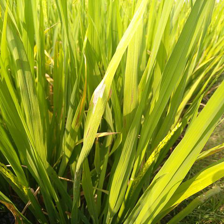

In [8]:
img.resize((224,224))

In [9]:
def f(i): return str(PILImage.create(i).size)

In [10]:
%time sizes = parallel(f, files, n_workers=4)

CPU times: user 4.27 s, sys: 772 ms, total: 5.04 s
Wall time: 15.6 s


In [11]:
%time pd.DataFrame(list(sizes)).value_counts()

CPU times: user 8.88 ms, sys: 0 ns, total: 8.88 ms
Wall time: 7.12 ms


(480, 640)    10403
(640, 480)        4
dtype: int64

In [12]:
df.variety.value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [13]:
df.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [14]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(480), batch_tfms=aug_transforms(size=224, min_scale=0.75))

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


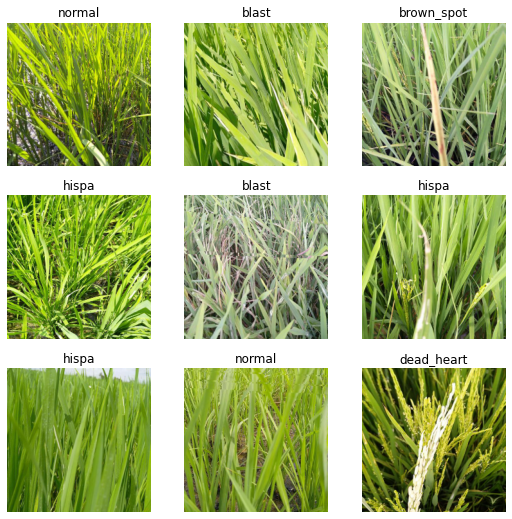

In [15]:
dls.show_batch();

# timm.list_models('*convnext*')

In [16]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate)

In [17]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.524760,0.765776,0.256127,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.797944,0.439844,0.138876,01:53


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

In [ ]:
learn.export('paddle.pkl')

In [ ]:
test_files = get_image_files(path/'test_images')

In [ ]:
test_dl = dls.test_dl(test_files)
test_dl.show_batch()

In [ ]:
my_submission_df = pd.read_csv(path/'sample_submission.csv'); my_submission_df

In [ ]:
probs, _, idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
result=pd.DataFrame({"image_id": [i.name for i in learn.dl.items],  "idx": idxs.numpy()})
mapping = dict(enumerate(dls.vocab))
result["label"]=result["idx"].map(mapping)
result.head(10)

In [ ]:
result.iloc[:,[0,2]].to_csv('submission_101.csv', index=False)

In [ ]:
!head submission_101.csv

### Making kaggle submission

In [ ]:
!kaggle competitions submit -f ~/mlworks/plant_disease_detection/submission_101.csv -m 'init convnext small 5 epochs' paddy-disease-classification

In [ ]:
import gc

In [ ]:
print(torch.cuda.list_gpu_processes())

In [ ]:
gc.collect()

In [ ]:
torch.cuda.empty_cache()